<a href="https://colab.research.google.com/github/luizmv8080/aprendizaje-profundo/blob/main/Tarea2/T2_Ejercicio2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Ejercicio 2 Tarea 2**


Luis Eduardo Mayorga Villalobos

In [ ]:
!pip install torch-summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Importar librerias
import random
from itertools import islice as take
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets.utils as tvutils
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.ops import Permute
from torchsummary import summary
from tqdm import tqdm
import torchvision.transforms.functional as TF
import torchvision.models as tvm
from skimage import io
from skimage.transform import resize
from sklearn.model_selection import train_test_split 
from PIL import Image

Funciones de ayuda

In [ ]:
# tamaño del lote
BATCH_SIZE = 32
# filas y columnas de la rejilla de imágenes
ROWS, COLS = 4, 8
# tamaño de la imagen
IMG_SIZE = 64


def crop_center(img, cropx, cropy):
    y, x = img.shape[:2]
    startx = x // 2 - cropx // 2
    starty = y // 2 - cropy // 2    
    return img[starty:starty+cropy, startx:startx+cropx]


def display_grid(xs, titles, rows, cols, figsize=(12, 6)):
    """Displays examples in a grid."""
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax[r, c].imshow(xs[i], cmap='gray')
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
            i += 1
    fig.tight_layout()
    plt.show()


def display_batch(x, titles, rows, cols, figsize=(12, 6)):
    """Displays a batch of processed examples in a grid."""
    # denormalizamos [0, 1] => [0, 255]
    x *= 255
    # rotamos canales (C x H x W) => (H x W x C)
    x = x.permute(0, 2, 3, 1)
    # convertimos a entero
    x = (x.numpy()).astype(np.uint8)
    # desplegamos
    display_grid(x, titles, rows, cols, figsize)


def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


def numpy_to_torch(x):
    x = transforms.functional.to_tensor(x)
    x = x.type(torch.float32)
    return x

def perdidad(losses):
  train_loss, test_loss = zip(*losses)
  plt.plot(train_loss,label='Train',marker='o',markersize=3)
  plt.plot(test_loss,label='Test',marker='o',markersize=3)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Perdida')
  plt.grid()
  plt.show()

set_seed()

Descargar el UTFKFace

In [ ]:
#Metemos la URL donde se descarga las imagenes de los rostros
URL = 'https://cloud.xibalba.com.mx/s/QpJdJ5aLEDG9Ryb/download'
#Nombramos la carpeta donde se va a guardar el archivo UTKFace
base_dir = '../data_rostros'
#El nombre del file descargado
filename = 'UTFKFace.tar.gz'
#La ruta del file
datadir = '../data/UTFKFace'
filepath = os.path.join(base_dir,filename)

#Creamos la carpeta donde meteremos UTKFace
! mkdir -p {base_dir}
#Descargamos el archivo tar y lo metemos en la carpeta data_rostros
! wget -nc {URL} -O {filepath}
#Descomprimimos el archivo tar
! tar -zxf {filepath} -C {base_dir}

--2022-11-12 21:58:30--  https://cloud.xibalba.com.mx/s/QpJdJ5aLEDG9Ryb/download
Resolving cloud.xibalba.com.mx (cloud.xibalba.com.mx)... 187.188.130.162
Connecting to cloud.xibalba.com.mx (cloud.xibalba.com.mx)|187.188.130.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106634631 (102M) [application/x-gzip]
Saving to: ‘../data_rostros/UTFKFace.tar.gz’

../data_rostros/UTF 100%[===================>] 101.69M  5.00MB/s    in 33s     

2022-11-12 21:59:05 (3.08 MB/s) - ‘../data_rostros/UTFKFace.tar.gz’ saved [106634631/106634631]



In [ ]:
#Creamos una lista de los nombres de las imagenes
path_im = '../data_rostros/UTKFace/'
nombres_imagenes = os.listdir('../data_rostros/UTKFace')

In [ ]:
#Creamos una lista donde se guardaran las etiquetas (edades) de cada una de las imagenes
#Los primeros caracteres numericos del nombre de las fotos significan la edad, por lo cual los extraemos
etiqueta = []
for i in nombres_imagenes:
  if i[:3].isdigit():
    etiqueta.append(float(i[:3]))
  elif i[:2].isdigit():
    etiqueta.append(float(i[:2]))
  elif i[:1].isdigit():
    etiqueta.append(float(i[:1]))
  

In [ ]:
#Nos aseguramos que efectivamente coincide la edad con las etiquetas
print(nombres_imagenes[100],'|',etiqueta[100])

36_0_3_20170117163531659.jpg.chip.jpg | 36.0


In [ ]:
class RecipesDS:

    def __init__(self, tsfm, nombres_imagenes, etiqueta, path_im):
          
        # guardamos la tranformación para las imágenes
        self.tsfm = tsfm
        # lista con las rutas a las imágenes
        self.paths = nombres_imagenes
        # lista con las etiquetas de las imágenes
        self.labels = etiqueta
        

    def __getitem__(self, i):
        # obtenemos la ruta de la imagen
        path = self.paths[i]
        # cargamos la imagen
        x = Image.open(path_im+path)
        # aplicamos transformación
        x = self.tsfm(x)
        # leeamos la etiqueta
        y = np.array(self.labels[i], np.float32).reshape(1)
        # regresamos el ejemplo
        return x, y

    def __len__(self):
        # número de ejemplos en el conjunto
        return len(self.paths)

VA]amos a echar un ojo a los datos

x shape=torch.Size([32, 64, 64, 3]) dtype=torch.uint8
y shape=torch.Size([32, 1]) dtype=torch.float32


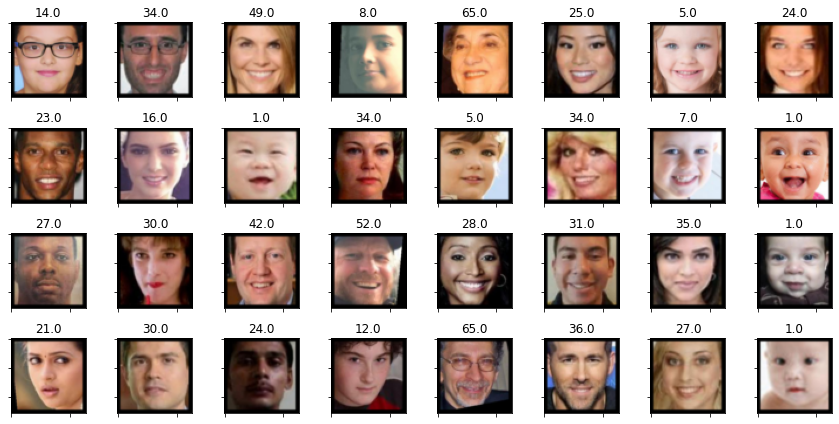

In [ ]:
tsfm = transforms.Compose([
    # recortamos al centro un poco todas las imagenes a 220x220
    transforms.CenterCrop(220),
    # redimensionamos a 64x64
    transforms.Resize(IMG_SIZE),
    # convertimos a ndarray
    np.array
])

ds = RecipesDS(tsfm,nombres_imagenes, etiqueta, path_im)

dl = DataLoader(
    # conjunto
    ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

# desplegamos un lote de imágenes
x, y = next(iter(dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
titles = [f'{l.item()}' for l in y]
display_grid(x, titles, ROWS, COLS)

Crear un dataframe para dividirlo en conjunto de entrenamiento y prueba

In [ ]:
dataframe = pd.DataFrame(list(zip(ds.paths,ds.labels)),columns=['Paths','Labels'])

In [ ]:
dataframe.head(2)

,Paths,Labels
0,58_1_0_20170120224803945.jpg.chip.jpg,58.0
1,45_1_0_20170117152126596.jpg.chip.jpg,45.0


Dividimos el dataset con datos de prueba y de entrenamiento

In [ ]:
data_train, data_test = train_test_split(dataframe, test_size = 0.20)

**Creamos el DataLoader para el conjunto de entrenamiento**

In [ ]:
tsfm_train = transforms.Compose([
    # recortamos al centro un poco todas las imagenes a 220x220
    transforms.CenterCrop(220),
    #Hacemos el rezise de todas las imagenes
    transforms.Resize(IMG_SIZE),
    #voltearla con fecto de espejo horzontal de forma aleatoria
    transforms.RandomHorizontalFlip(),
    # convertimos a ndarray
    transforms.ToTensor(),
])

nombres_imagenes_train = list(data_train['Paths'])
etiqueta_train = list(data_train['Labels'])

ds_train = RecipesDS(tsfm_train,nombres_imagenes_train, etiqueta_train, path_im)

dl_train = DataLoader(
    # conjunto
    ds_train,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

# desplegamos un lote de imágenes
x_train, y_train = next(iter(dl_train))
print(f'x shape={x_train.shape} dtype={x_train.dtype}')
print(f'y shape={y_train.shape} dtype={y_train.dtype}')
titles = [f'{l.item()}' for l in y_train]

x shape=torch.Size([32, 3, 64, 64]) dtype=torch.float32
y shape=torch.Size([32, 1]) dtype=torch.float32


**Creamos el DataLoader para el conjunto de prueba**

Aqui no aplicamos el aumento de datos con el espejo horizontal

In [ ]:
tsfm_test = transforms.Compose([
    # recortamos al centro un poco todas las imagenes a 220x220
    transforms.CenterCrop(220),
    #Hacemos el rezise de todas las imagenes
    transforms.Resize(IMG_SIZE),
    # convertimos a ndarray
    transforms.ToTensor(),
])

nombres_imagenes_test = list(data_test['Paths'])
etiqueta_test = list(data_test['Labels'])

ds_test = RecipesDS(tsfm_test,nombres_imagenes_test, etiqueta_test, path_im)

dl_test = DataLoader(
    # conjunto
    ds_test,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

# desplegamos un lote de imágenes
x_test, y_test = next(iter(dl_test))
print(f'x shape={x_test.shape} dtype={x_test.dtype}')
print(f'y shape={y_test.shape} dtype={y_test.dtype}')
titles = [f'{l.item()}' for l in y_test]

x shape=torch.Size([32, 3, 64, 64]) dtype=torch.float32
y shape=torch.Size([32, 1]) dtype=torch.float32


Ahora creamos el bloque ConvNext

In [ ]:
class ConvNext(nn.Module):

  def __init__(self,dim):
    
    super(ConvNext, self).__init__()

    dim_out = dim*4

    self.cnn_block = nn.Sequential(
        nn.Conv2d(in_channels=dim, out_channels=dim, kernel_size=7, padding=3, groups = dim),
        Permute([0,2,3,1]),
        #Permutamos para que no afecte al LayerNorm
        nn.LayerNorm(dim),
        nn.Linear(dim, dim_out),
        nn.GELU(),
        nn.Linear(dim_out,dim),
        #Volvemos a aplicar la prmutacion
        Permute([0,3,1,2]),
    )

  def forward(self, x):
    x1 = self.cnn_block(x)
    x = x1 + x
    return x

Definimos toda la arquitectura completa

In [ ]:
class ArquiCompleta(nn.Module):

  def __init__(self,dim):
    super(ArquiCompleta, self).__init__()

    #Dado que al final nuestra matriz se reducira de 64 => 32 en las dos dimensiones
    #Y sera un tensor de tres canales, entonces el total de features de salida sera 
    # un vector de 3*32*32
    
    self.num_features = 3*32*32

    self.cnn = nn.Sequential(
        ConvNext(dim),
        nn.MaxPool2d(kernel_size=2, stride=2),     
    )

    self.flatten = nn.Flatten()
    self.reg = nn.Linear(self.num_features,1)

  def forward(self, x):
    x = self.cnn(x)
    x = self.flatten(x)
    x = self.reg(x)
    return x

**Creamos las funciones para el entrenamiento y para desplegar los resultados**

In [ ]:
def train_epoch(data_loader,model,opt,epoch):
  
  for x, y_true in data_loader:
    #Movemos todo al dispositivo 
    x = x.to(device)
    y_true = y_true.to(device)
    y_hat = model(x)
    loss = F.mse_loss(y_hat, y_true)

    #Despues de calcular la funcion de perdida, vaciamos los gradientes para retropropagar
    #y finalmente actualizar los parametros
    opt.zero_grad() 
    loss.backward() 
    opt.step()

def eval_epoch(data_loader, model, epoch):
  
  with torch.no_grad():
    losses = []

    for x, y_true in data_loader:
      x = x.to(device)
      y_true = y_true.to(device)
      y_hat = model(x)

      loss_b = F.mse_loss(y_hat, y_true)
      losses.append(loss_b.item())
    
    loss = np.mean(losses)
    return loss

def train(model, train_dl, test_dl,epochs,lr):
  
  model = model.to(device)
  loss_hist = []


  optimizer = optim.Adam(model.parameters(),lr=lr)
  range_progress = range(epochs)  

  # Ponemos el modelo en modo evaluacion
  model.eval()


  for epoch in range_progress:
  
    model.train()
    train_epoch(train_dl,model,optimizer,epoch)
    model.eval()
    train_loss = eval_epoch(train_dl, model, epoch)
    test_loss = eval_epoch(test_dl, model, epoch)

    # Vamos actualizando el historial
    loss_hist.append([train_loss,test_loss])
    
    print(f'E{epoch:02} '
            f'loss=[{train_loss:6.2f},{test_loss:6.2f}] ')
      
  return loss_hist

In [ ]:
#Creamos funcion para desplegar los resultados
def desplegarResultados(dl,modelo):
  modelo.to(device).eval()
  with torch.no_grad():
    x, y_true = next(iter(dl))
    y_pred = modelo(x.to(device))
    titles = []
    for i in range(len(y_true)):
      titles.append(f'y={int(y_true[i].item())},y_pre={int(y_pred[i].item())}')
    display_batch(x, titles, ROWS, COLS)

In [ ]:
#Veamos un summary del modelo pasandole una imagen de 64x64 con dim = 3 (R,G,B)
model_rc = ArquiCompleta(3)
summary(model_rc, (3, 64, 64), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 32, 32]           --
|    └─ConvNext: 2-1                     [-1, 3, 64, 64]           --
|    |    └─Sequential: 3-1              [-1, 3, 64, 64]           243
|    └─MaxPool2d: 2-2                    [-1, 3, 32, 32]           --
├─Flatten: 1-2                           [-1, 3072]                --
├─Linear: 1-3                            [-1, 1]                   3,073
Total params: 3,316
Trainable params: 3,316
Non-trainable params: 0
Total mult-adds (M): 0.61
Input size (MB): 0.05
Forward/backward pass size (MB): 0.66
Params size (MB): 0.01
Estimated Total Size (MB): 0.72


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 32, 32]           --
|    └─ConvNext: 2-1                     [-1, 3, 64, 64]           --
|    |    └─Sequential: 3-1              [-1, 3, 64, 64]           243
|    └─MaxPool2d: 2-2                    [-1, 3, 32, 32]           --
├─Flatten: 1-2                           [-1, 3072]                --
├─Linear: 1-3                            [-1, 1]                   3,073
Total params: 3,316
Trainable params: 3,316
Non-trainable params: 0
Total mult-adds (M): 0.61
Input size (MB): 0.05
Forward/backward pass size (MB): 0.66
Params size (MB): 0.01
Estimated Total Size (MB): 0.72

In [ ]:
! nvidia-smi

Sat Nov 12 21:59:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
#Desplegamos los resultados de perdida tanto de entrenamiento como de prueba
loss_modelo = train(model_rc, dl_train, dl_test,epochs=15,lr=1e-4)

E00 loss=[428.67,440.31] 
E01 loss=[413.01,422.53] 
E02 loss=[394.52,406.77] 
E03 loss=[376.91,387.93] 
E04 loss=[361.03,370.52] 
E05 loss=[349.43,357.97] 
E06 loss=[340.72,349.17] 
E07 loss=[332.90,343.56] 
E08 loss=[326.62,334.48] 
E09 loss=[320.01,330.06] 
E10 loss=[314.00,322.17] 
E11 loss=[310.03,319.39] 
E12 loss=[303.84,316.12] 
E13 loss=[299.61,307.81] 
E14 loss=[296.77,304.24] 


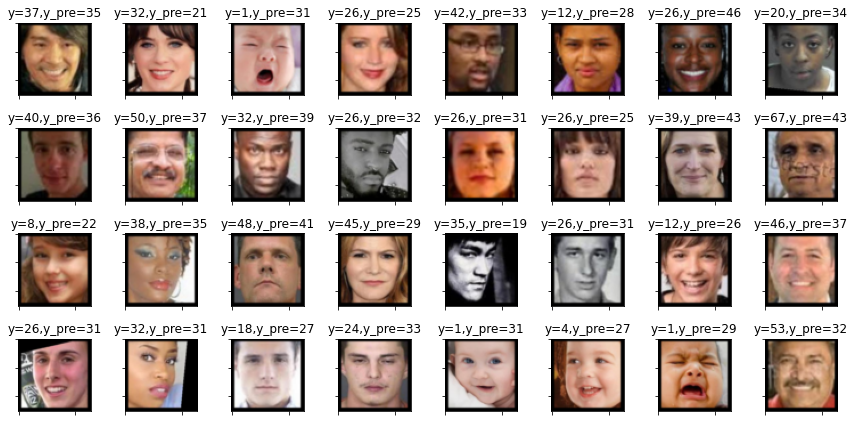

In [ ]:
#Vamos a ver la comparacion de los resultados
desplegarResultados(dl_test, model_rc)

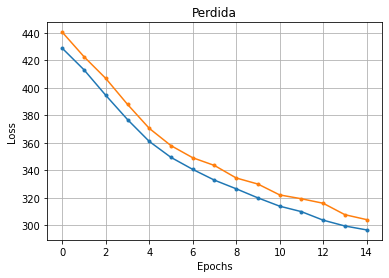

In [ ]:
perdidad(loss_modelo)

**Entrenando un modelo reentrenando solo la última capa.**

In [ ]:
#Creamos una clase para crear el modelo reentrenando solo la última capa
class TransferModel(nn.Module):
  def __init__(self, pretrained):
    super(TransferModel, self).__init__()

    #Cargamos un modelo preentrenado el cual sera el mobilenet_v2
    #Y solo le pasamos el parametro pretrained
    self.cnn = tvm.mobilenet_v2(pretrained=pretrained)
    #Ahora, tambien reemplazamos la FC y ponemos Identity
    self.cnn.fc = nn.Identity()

    in_features = 1000
    self.reg = nn.Sequential(
        nn.BatchNorm1d(in_features),
        nn.Linear(in_features,1)
    )
  
  def forward(self, x):
    x = self.cnn(x)
    x = self.reg(x)
    return x

  # Creamos un metodo para congelar los parametros de la CNN
  def freeze_features(self,freeze=True):
    requires_grad = not freeze
    for param in self.cnn.parameters():
      param.requires_grad = requires_grad


In [ ]:
def train_epoch_pre(data_loader,model,opt,epoch):

  for x, y_true in data_loader:
    x = x.to(device)
    y_true = y_true.to(device)
    y_hat = model(x)
    loss = F.mse_loss(y_hat, y_true)
    opt.zero_grad() 
    loss.backward() 
    opt.step() 

def eval_epoch_pre(data_loader, model, epoch):
  
  with torch.no_grad():
    
    losses = []
    for x, y_true in data_loader:
      x = x.to(device)
      y_true = y_true.to(device)
      y_hat = model(x) 
      loss_b = F.mse_loss(y_hat, y_true) 
      losses.append(loss_b.item())

    loss = np.mean(losses)
    return loss

def train_pre(model, train_dl, test_dl,epochs,lr):
  
  model = model.to(device)
  loss_hist = []
  optimizer = optim.Adam(model.parameters(),lr=lr)

  #Como en este caso no queremos reentrenar toda la red, simplemente congelamos
  # todos los parametros en este punto
  model.freeze_features(True) 
  
  range_progress = range(epochs)  
  model.eval()

  
  for epoch in range_progress:
    model.train()
    train_epoch_pre(train_dl,model,optimizer,epoch)
    model.eval()
    train_loss = eval_epoch_pre(train_dl, model, epoch)
    test_loss = eval_epoch_pre(test_dl, model, epoch)
    loss_hist.append([train_loss,test_loss])

    
    print(f'E{epoch:02} '
            f'loss=[{train_loss:6.2f},{test_loss:6.2f}] ')
      
  return loss_hist

In [ ]:
# Instanciamos el modelo y congelamos los features de la CNN
model_tf = TransferModel(pretrained=True)
model_tf.freeze_features()
# Ponemos el modelo en modo de evaluacion
_ = model_tf.eval()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [ ]:
loss_modelo_pre = train_pre(model_tf, dl_train, dl_test,epochs=15,lr=1e-4)

E00 loss=[1297.52,1346.08] 
E01 loss=[807.14,832.08] 
E02 loss=[393.77,408.10] 
E03 loss=[303.28,309.58] 
E04 loss=[290.91,296.72] 
E05 loss=[286.78,295.21] 
E06 loss=[279.27,284.75] 
E07 loss=[278.68,287.08] 
E08 loss=[274.54,282.04] 
E09 loss=[269.73,278.27] 
E10 loss=[267.54,273.92] 
E11 loss=[268.68,275.68] 
E12 loss=[265.99,273.58] 
E13 loss=[266.47,272.03] 
E14 loss=[265.02,271.85] 


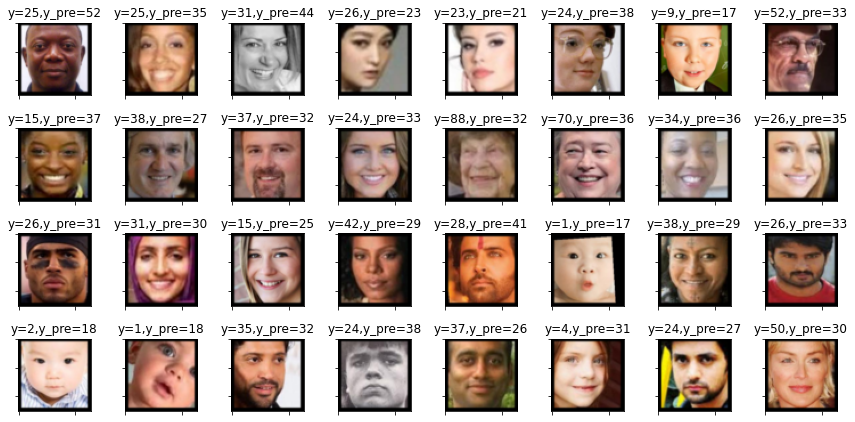

In [ ]:
desplegarResultados(dl_test, model_tf)

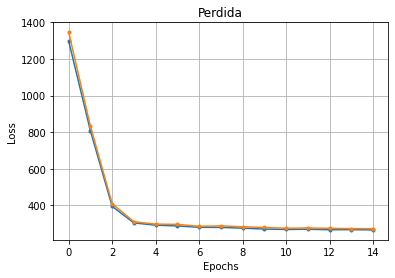

In [ ]:
perdidad(loss_modelo_pre)

**Reentrenando toda la red**

In [ ]:
def train_epoch_full(data_loader,model,opt,epoch):

  for x, y_true in data_loader:
    x = x.to(device)
    y_true = y_true.to(device)
    y_hat = model(x)
    loss = F.mse_loss(y_hat, y_true)
    opt.zero_grad() 
    loss.backward() 
    opt.step() 

def eval_epoch_full(data_loader, model, epoch):
  
  with torch.no_grad():
    
    losses = []
    for x, y_true in data_loader:
      x = x.to(device)
      y_true = y_true.to(device)
      y_hat = model(x) 
      loss_b = F.mse_loss(y_hat, y_true) 
      losses.append(loss_b.item())

    loss = np.mean(losses)
    return loss

def train_full(model, train_dl, test_dl,epochs,lr):
  
  model = model.to(device)
  loss_hist = []
  optimizer = optim.Adam(model.parameters(),lr=lr)

  #Al contrario del entrenamiento cuando no se hace reentrenado de toda la red
  # ahora si no mantenemos congelados todos los parametros para que ahora si se 
  # fluya completamente
  model.freeze_features(False)
  
  range_progress = range(epochs)  
  model.eval()

  
  for epoch in range_progress:
    model.train()
    train_epoch_full(train_dl,model,optimizer,epoch)
    model.eval()
    train_loss = eval_epoch_full(train_dl, model, epoch)
    test_loss = eval_epoch_full(test_dl, model, epoch)
    loss_hist.append([train_loss,test_loss])

    
    print(f'E{epoch:02} '
            f'loss=[{train_loss:6.2f},{test_loss:6.2f}] ')
      
  return loss_hist

In [ ]:
# Instanciamos el modelo y congelamos los features de la CNN
model_tf_full = TransferModel(pretrained=True)
model_tf_full.freeze_features()
# Ponemos el modelo en modo de evaluacion
_ = model_tf_full.eval()

In [ ]:
loss_modelo_full = train_full(model_tf_full, dl_train, dl_test,epochs=15,lr=1e-4)

E00 loss=[987.60,998.63] 
E01 loss=[442.95,453.72] 
E02 loss=[116.32,137.32] 
E03 loss=[ 48.96, 72.44] 
E04 loss=[ 51.38, 77.15] 
E05 loss=[ 38.47, 69.43] 
E06 loss=[ 37.11, 70.58] 
E07 loss=[ 32.29, 64.84] 
E08 loss=[ 35.18, 70.43] 
E09 loss=[ 26.23, 65.22] 
E10 loss=[ 31.43, 72.08] 
E11 loss=[ 23.64, 66.19] 
E12 loss=[ 20.73, 66.02] 
E13 loss=[ 19.30, 63.79] 
E14 loss=[ 18.42, 63.92] 


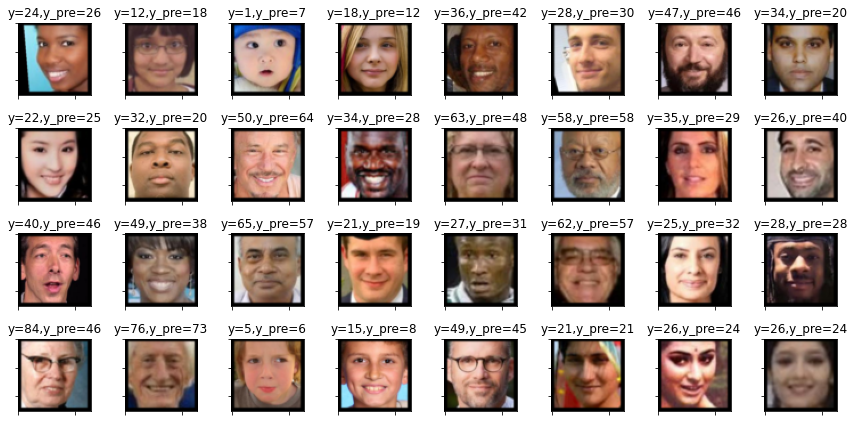

In [ ]:
desplegarResultados(dl_test, model_tf_full)

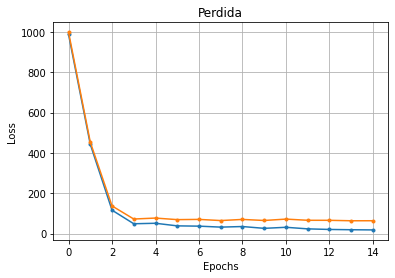

In [ ]:
perdidad(loss_modelo_full)

**Podemos ver que al parecer el modo mas eficiente es reentrenando todo el modelo, se llega a una perdida de entrenamiento de 19.22 y para el de prueba de 65, aunque a partir de la epoca 6 se incrementa el overfitting. Se podria mejorar el modelo cambiando hiperparametros como el "lr", aunque tambien cambiando el modelo que hara la transferencia de conocimiento, en este caso usamos la mobilenet_v2, pero podriamos usar la resnet50 y probar su eficiencia. En los dos casos, la transferencia si mejora la prediccion de las edades.**



